In [1]:
#pip install tensorflow -i  https://pypi.mirrors.ustc.edu.cn/simple/

### 二分类：Sigmoid+binary_crossentropy
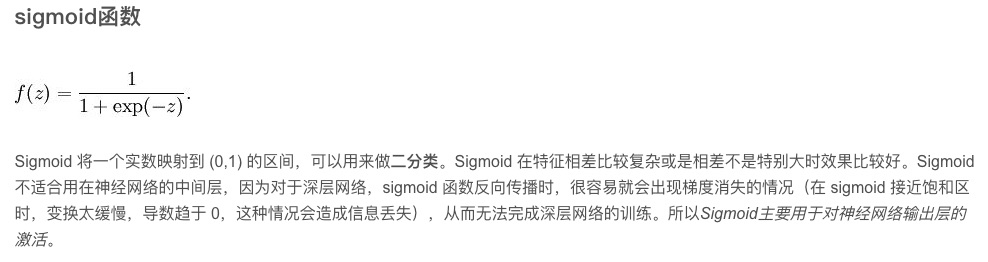

### 多分类：softmax+categorical_crossentropy

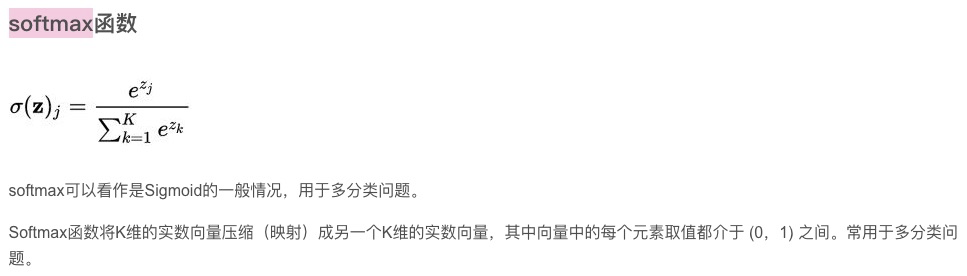

### 1，库导入

In [36]:
# Standard Imports
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization


# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
#https://keras.io/zh/applications/

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

### 数据路径配置

In [37]:
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/home/moyan/chest_xray/train'
TEST_PATH = '/home/moyan/chest_xray/test'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

In [38]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1349
Pneumonia images in train-set:  3883
Total images in train-set:  5232 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5856


### 数据预处理和数据划分

In [39]:
# Data-Augmentation Parameters to ImageDataGenerator “即时”数据扩充（即不会在训练之前生成这些示例）;
train_datagen = ImageDataGenerator(validation_split=0.1,
                                   rescale=1./255,
                                   rotation_range=5, # 在0到5度之间随机旋转我的图像。
                                   width_shift_range=0.1, # 水平shift.
                                   height_shift_range=0.1, # 垂直shift.
                                   zoom_range=0.1, # Zoom.尺度
                                   horizontal_flip=True, # 随机水平翻转
                                   samplewise_center=True, # 样本设置为均值0
                                   samplewise_std_normalization=True) # 样本方差
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()


# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255,samplewise_center=True,  
                                   samplewise_std_normalization=True)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [40]:
TEST_PATH

'/home/moyan/chest_xray/test'

In [41]:
test_generator

### 展示处理后的效果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

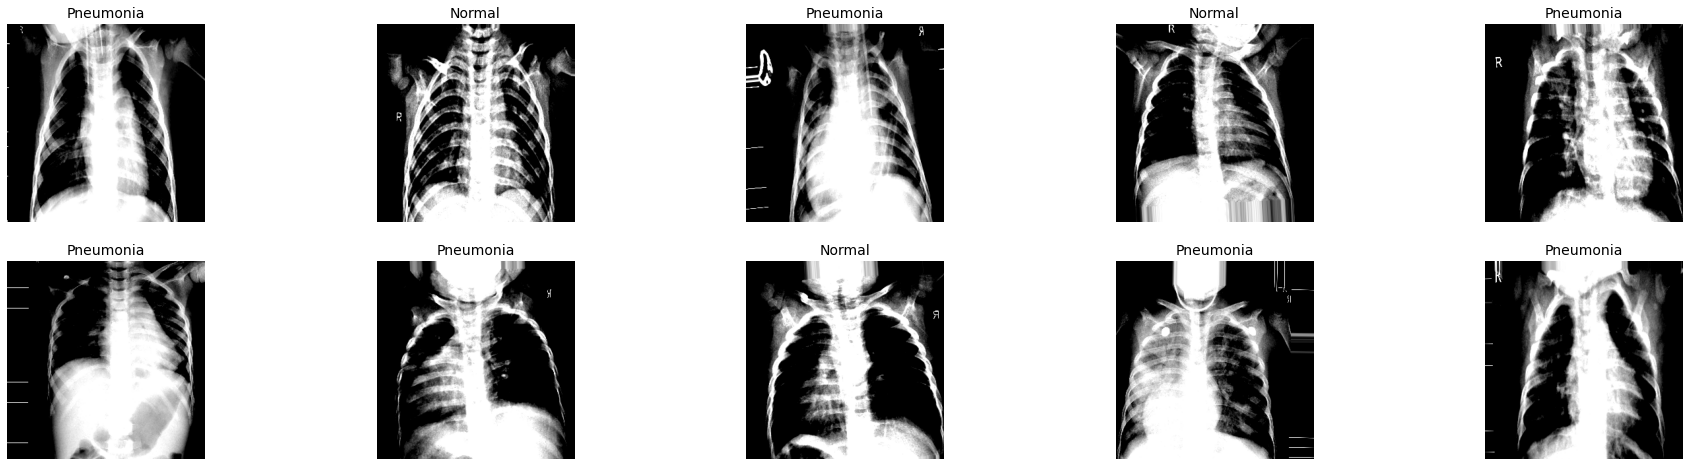

In [42]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

### 不同模型的创立：
* inceptionV3
* Resnet-50 (直接修改输出)
* Resnet-50（缓慢收敛）
* VGG16
* Densenet 169（缓慢收敛）
* xception（缓慢收敛）

### inceptionV3

In [43]:
# InceptionV3 with Transfer Learning
def craete_model():
    
    # Load v3 model without the top layer
    inception_v3_model = InceptionV3(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)

    # Freeze
    inception_v3_model.trainable = False  #删除最后三层并显示 mixed_10 层
    
    # New classifier layers
    flatten = Flatten()(inception_v3_model.layers[-1].output) # Flatt last v3 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=inception_v3_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [44]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [39]:
#resnet = ResNet50(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)
#resnet.summary()

In [28]:
#resnet.output

<KerasTensor: shape=(None, 10, 10, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [40]:
print(tf.__version__)
print(tf.keras.__version__)

2.5.0
2.5.0


### Resnet

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.layers import Flatten, Dense, Dropout
#from keras.models import Sequential
#from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,GlobalAveragePooling2D,AveragePooling2D


In [13]:
#from keras.models import Sequential
#from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,GlobalAveragePooling2D,AveragePooling2D
TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

In [14]:
def craete_model_Resnet():
    
    # Load  model without the top layer
    resnet_model = ResNet50( weights='imagenet', include_top=False,input_shape=INPUT_SIZE)
    
    # Freeze
    resnet_model.trainable = False
     #New classifier layers
    flatten = Flatten()(resnet_model.output)  #压成1维向量
    fc1 = Dense(units=512, activation='relu')(flatten)
    
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
    
    # Define a new Model
    model = Model(inputs=resnet_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model_Resnet()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
def craete_model_Resnet2():
    
    # Load  model without the top layer
    resnet_model = ResNet50(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)
    
    # Freeze
    resnet_model.trainable = False
    
     #New classifier layers
    flatten = Flatten()(resnet_model.output)
    fc1  = Dense(1024, activation='relu')(flatten)
    # 因为前面输出的dense feature太多了，我们这里加入dropout layer来防止过拟合
    dropout1 = Dropout(0.5)(fc1)
    fc2 = Dense(512, activation='relu')(dropout1)
    dropout = Dropout(0.3)(fc2)
    output =Dense(2, activation='softmax')(dropout)
    
    
    # Define a new Model
    model = Model(inputs=resnet_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model_Resnet2()

### VGG

In [68]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

In [69]:
def craete_model_vgg16():
    
    # Load  model without the top layer
    vgg_model = VGG16(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)
    
    # Freeze
    vgg_model.trainable = False
    
     #New classifier layers
    flatten = Flatten()(vgg_model.output)
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
    
    # Define a new Model
    model = Model(inputs=vgg_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model_vgg16()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

### Desnet

In [93]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

In [94]:
def craete_model_desnet():
    
    # Load  model without the top layer
    desnet_model = DenseNet169(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)
    
    # Freeze
    desnet_model.trainable = False
    out = desnet_model.layers[-1].output
    out = Flatten()(out)
    out  = Dense(1024, activation='relu')(out)
    # 因为前面输出的dense feature太多了，我们这里加入dropout layer来防止过拟合
    out = Dropout(0.5)(out)
    out = Dense(512, activation='relu')(out)
    out = Dropout(0.3)(out)
    output =Dense(2, activation='softmax')(out)

    # Define a new Model
    model = Model(inputs=desnet_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model_desnet()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### xception

In [133]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.layers import Flatten, Dense, Dropout

TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

def craete_model_xception():
    
    # Load  model without the top layer
    xception_model = Xception(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)
    
    # Freeze
    xception_model.trainable = False
    out = xception_model.layers[-1].output
    out = Flatten()(out)
    out  = Dense(1024, activation='relu')(out)
    # 因为前面输出的dense feature太多了，我们这里加入dropout layer来防止过拟合
    out = Dropout(0.5)(out)
    out = Dense(512, activation='relu')(out)
    out = Dropout(0.3)(out)
    output =Dense(2, activation='sigmoid')(out)

    # Define a new Model
    model = Model(inputs=xception_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model_xception()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### 封装：优化器，学习率和acc配置

In [139]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [140]:
my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='my_model_xception.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)]

In [ ]:
#from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
#model.fit(train_x, train_y, batch_size=32, epochs=300, validation_split=0.1, callbacks=[reduce_lr])


In [141]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'  #显卡配置

In [142]:
EPOCHS=20
BATCH_SIZE=128

In [143]:
history = model.fit(train_generator, # If x is a dataset -> y should not be specified (since targets will be obtained from x).
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model0702_xception.h5')

Epoch 1/20
74/74 [==============================] - 419s 6s/step - loss: 0.2140 - accuracy: 0.9123 - val_loss: 0.0926 - val_accuracy: 0.9693

Epoch 00001: val_accuracy improved from -inf to 0.96935, saving model to my_model_xception.h5
Epoch 2/20
74/74 [==============================] - 456s 6s/step - loss: 0.1416 - accuracy: 0.9456 - val_loss: 0.0921 - val_accuracy: 0.9674

Epoch 00002: val_accuracy did not improve from 0.96935
Epoch 3/20
74/74 [==============================] - 468s 6s/step - loss: 0.1379 - accuracy: 0.9476 - val_loss: 0.0822 - val_accuracy: 0.9732

Epoch 00003: val_accuracy improved from 0.96935 to 0.97318, saving model to my_model_xception.h5
Epoch 4/20
74/74 [==============================] - 481s 6s/step - loss: 0.1277 - accuracy: 0.9507 - val_loss: 0.0679 - val_accuracy: 0.9732

Epoch 00004: val_accuracy did not improve from 0.97318
Epoch 5/20
74/74 [==============================] - 467s 6s/step - loss: 0.1121 - accuracy: 0.9569 - val_loss: 0.0650 - val_accurac

In [144]:
from keras.models import load_model

#model = load_model('my_model0628_resnet_1.h5')
#model = load_model('my_model0702InceptionV3.h5')
#model = load_model('my_model0702_vgg16.h5')
#model = load_model('my_model0702_desnet.h5')
model = load_model('my_model0702_xception.h5')

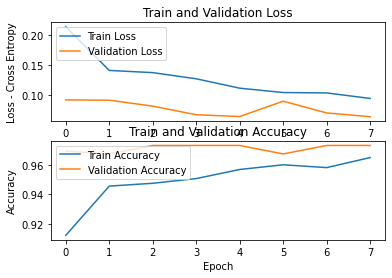

In [145]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [146]:
from keras.models import load_model
#model = load_model('my_model0628_resnet_1.h5')
#model = load_model('my_model0702InceptionV3.h5')
#model = load_model('my_model0702_vgg16.h5')
#model = load_model('my_model0702_desnet.h5')
model = load_model('my_model0702_xception.h5')
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [24]:
#pip install graphviz

In [25]:
#pip install pydot

In [22]:
#from tensorflow.keras.utils import plot_model

In [26]:
#plot_model(model, to_file='model.png')

In [67]:
# 保存参数，载入参数
#model.save_weights('my_model_weights0624.h5')
#model.load_weights('my_model_weights0624.h5')
# 保存网络结构，载入网络结构
#from keras.models import model_from_json
#json_string = model.to_json()
#model2 = model_from_json(json_string)
 
#print(json_string)


In [71]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'  #显卡配置

In [148]:
from keras.models import load_model
#model = load_model('my_model0628_resnet_2.h5')
#model = load_model('my_model0628_resnet_1.h5')
#model = load_model('my_model0702InceptionV3.h5')
#model.load_weights('my_model_weights0624.h5')
#model = load_model('my_model0702_vgg16.h5')
#model = load_model('my_model0702_desnet.h5')
model = load_model('my_model0702_xception.h5')

In [149]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [119]:
#test_loss, test_accuracy = model.evaluate(test_generator, verbose=0) 无限循环装载数据

In [150]:
# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255,samplewise_center=True,  
                                   samplewise_std_normalization=True)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = 624, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 624 images belonging to 2 classes.


In [152]:
image_test.shape

(624, 300, 300, 3)

In [ ]:
#test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

In [153]:
test_loss, test_accuracy = model.evaluate(image_test, label_test, verbose=1)

test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

20/20 [==============================] - 41s 2s/step - loss: 0.1815 - accuracy: 0.9311
Test Loss:  0.18151
Test Accuracy:  93.109 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

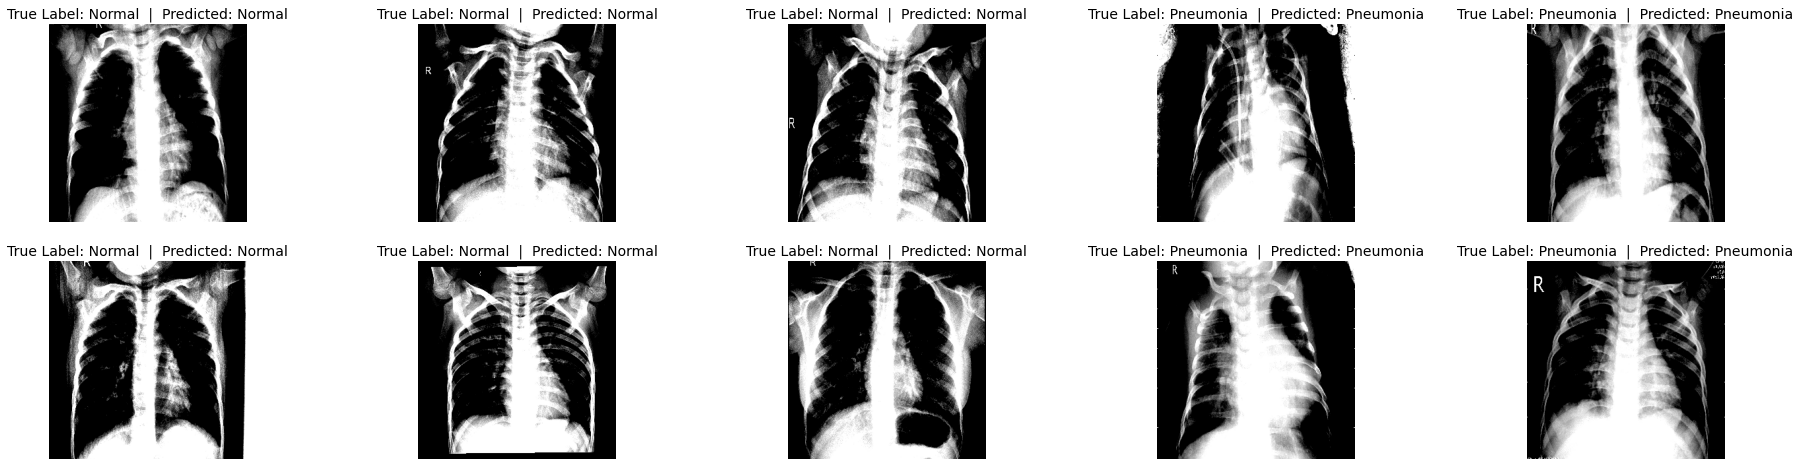

In [154]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

In [155]:
# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255,samplewise_center=True,  
                                   samplewise_std_normalization=True)
test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = 624, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 624 images belonging to 2 classes.


In [156]:
image_test.shape

(624, 300, 300, 3)

In [157]:
y_pred = model.predict(image_test,verbose=1).argmax(axis=-1)

20/20 [==============================] - 39s 2s/step


In [158]:
print(y_pred)

[1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1
 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1
 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0
 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0
 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1
 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1
 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0
 1 1 0 1 0 1 0 1 1 1 1 1 

In [159]:
label_test0=label_test[:,1]
array = label_test0.astype(np.int)
array

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [160]:
label_0=list(np.array(array).flatten()) 

In [146]:
#label_0

Text(0.5, 1.0, 'Confusion Matrix')

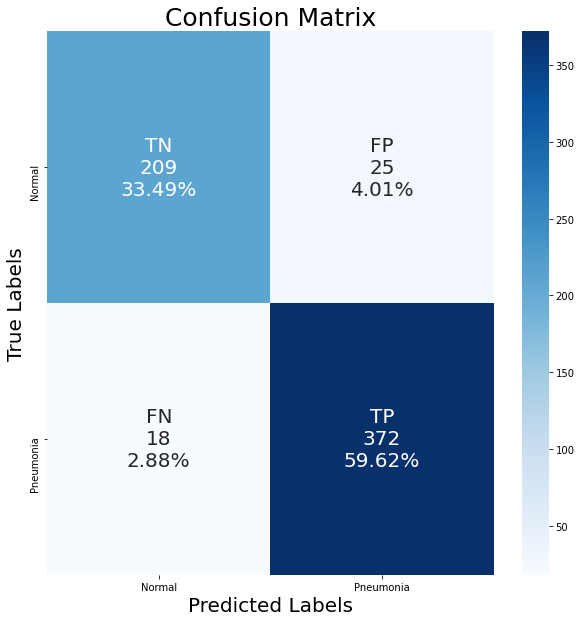

In [161]:
conf_mat = confusion_matrix(label_0, y_pred)


group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)

In [162]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  96.5 %
Validation Accuracy:  97.32 %
Test Accuracy:  93.109 %
